In [1]:
# using LinearAlgebra
using SparseArrays
# using Random
using CairoMakie
# using Statistics
# using ProgressMeter
using DataFrames
using StatsBase
using DelimitedFiles

In [2]:
include("EchoStateNetworksStochastic.jl")
using .EchoStateNetworksStochastic
include("ONReservoir.jl")
using .ONReservoir
include("TurningError.jl")
using .TurningError

In [3]:
ts_str = ["x", "y", "z"];

In [ ]:
lo_train = vec(readdlm("lorenz_train.txt"))
lo_test = vec(readdlm("lorenz_test.txt"))

fig = Figure( size = (1200,600) )
lines!(Axis(fig[1,1]), lo_train; linewidth = 1.0, color = Cycled(1))
lines!(Axis(fig[1,2]), lo_test; linewidth = 1.0, color = Cycled(2))
fig

In [ ]:
test_ON_part_adjacency = [
    0 0.1 0.2;
    0 0 0.3;
    0.4 0 0
]

k = 8
d = 3
ρ = 2.0
α = 1.0
η = 1/maximum(lo_train)
β = 0.001

ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=3, ON_part_adjacency=test_ON_part_adjacency)

DataFrame(ESN_params.V_rec, :auto)

In [ ]:
m = 3
k = 4
part_connection=0.5
d = k*0.05
ρ = 1.2
α = 1.0
η = 1/maximum(lo_train)
β = 0.001
w = 1
τ = 2

window_size = (m-1)*τ
    
part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
num_partitions = length(unique_partitions_train)
# trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, ON_part_adjacency=trans_adjacency_matrix)

R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train, ON_part_adjacency=trans_adjacency_matrix)


part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
preds, test_states = one_step_pred(lo_test, ESN_params, R, S = train_states[end,:], partition_symbols=part_symbols_test, ON_part_adjacency=trans_adjacency_matrix)

In [ ]:
m = 3
k = 4
part_connection=0.5
d = k*0.05
ρ = 1.2
α = 1.0
η = 1/maximum(lo_train)
β = 0.001
w = 1
τ = 2

window_size = (m-1)*τ
    
part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
num_partitions = length(unique_partitions_train)
# trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, ON_part_adjacency=trans_adjacency_matrix)

R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train, ON_part_adjacency=trans_adjacency_matrix)


part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
preds, test_states = one_step_pred(lo_test, ESN_params, R, S = train_states[end,:], partition_symbols=part_symbols_test, ON_part_adjacency=trans_adjacency_matrix)

In [ ]:
trans_adjacency_matrix

In [ ]:
DataFrame(ESN_params.V_rec, :auto)

In [ ]:
function RMSE(y_true, y_pred)
    return sqrt(mean((y_true .- y_pred) .^ 2))
end

In [ ]:
test_preds = lo_test + 3 * randn(length(lo_test))

test_mask = create_turning_partition_mask(lo_test, 4, 1, 1)
error = test_preds .- lo_test

fig = Figure( size = (1200,600))

ax1 = Axis(fig[1,1])
lines!(ax1, lo_test; linewidth = 1.0, color = Cycled(1))
lines!(ax1, test_preds .* test_mask; linewidth = 1.0, color = Cycled(2))
lines!(ax1, error .* test_mask; linewidth = 1.0, color = Cycled(3))

xlims!(600,700)

fig

In [ ]:
function compare_preds(ON_preds, vanilla_preds, x_start, x_end; calculate_error=true, ignore_first=0, offset=1)
    ON_preds_cropped = ON_preds[ignore_first+1:end]
    vanilla_preds_cropped = vanilla_preds[ignore_first+1:min(length(ON_preds), end)]
    lo_test_cropped = lo_test[offset+ignore_first+1:min(length(ON_preds_cropped)+offset+ignore_first, end)]

    if calculate_error
        println("Ordinal network reservoir prediction RMSE: ", RMSE(ON_preds_cropped, lo_test_cropped))
        println("Vanilla prediction RMSE: ", RMSE(vanilla_preds_cropped, lo_test_cropped))
        println("Ordinal network reservoir prediction turning partition RMSE: ", turning_partition_RMSE(ON_preds_cropped, lo_test_cropped))
        println("Vanilla prediction turning partition RMSE: ", turning_partition_RMSE(vanilla_preds_cropped, lo_test_cropped))
    end

    fig = Figure( size = (1200,600))

    ax1 = Axis(fig[1,1])
    lines!(ax1, ON_preds_cropped; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test_cropped; linewidth = 1.0, color = Cycled(2))

    xlims!(x_start,x_end)
    ylims!(-25,25)

    ax2 = Axis(fig[1,2])
    lines!(ax2, vanilla_preds_cropped; linewidth = 1.0, color = Cycled(1))
    lines!(ax2, lo_test_cropped; linewidth = 1.0, color = Cycled(2))

    xlims!(x_start,x_end)
    ylims!(-25,25)

    fig
end

## Single step predictions

In [ ]:
function create_pred_for_params(m; k = 100, part_connection=0.5, d = k*0.05, ρ = 1.2, α = 1.0, η = 1/maximum(lo_train), β = 0.001, w = 1, τ = 2)
    window_size = (m-1)*τ
    
    part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
    trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
    num_partitions = length(unique_partitions_train)
    # trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

    ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, ON_part_adjacency=trans_adjacency_matrix)

    R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train, ON_part_adjacency=trans_adjacency_matrix)

    println("Created reservoir of size: ", size(train_states[end,:]))

    part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
    preds, test_states = one_step_pred(lo_test, ESN_params, R, S = train_states[end,:], partition_symbols=part_symbols_test, ON_part_adjacency=trans_adjacency_matrix)

    return(preds[1:end-length(unique_partitions_test)])
end

### Equal size of overall reservoir

#### 600 total size

In [15]:
# good candidate for multithreading
ON_preds = create_pred_for_params(3; k = 100, part_connection=1)
vanilla_preds = create_pred_for_params(1; k = 600)
;

Created reservoir of size: (

In [ ]:
compare_preds(ON_preds, vanilla_preds, 500, 600, ignore_first=20)

#### 60 overall size

In [ ]:
ON_preds = create_pred_for_params(3; k = 10, d=2, part_connection=1)
vanilla_preds = create_pred_for_params(1; k = 60)
;

In [ ]:
compare_preds(ON_preds, vanilla_preds, 0, 100, ignore_first=20)

### Equal k

#### k = 100

In [ ]:
# good candidate for multithreading
ON_preds = create_pred_for_params(3; k = 100, part_connection=1)
vanilla_preds = create_pred_for_params(1; k = 100)
;

In [ ]:
compare_preds(ON_preds, vanilla_preds, 500, 600, ignore_first=20)

#### k = 10

In [ ]:
# good candidate for multithreading
ON_preds = create_pred_for_params(3; k = 10, part_connection=1)
vanilla_preds = create_pred_for_params(1; k = 10)
;

In [ ]:
compare_preds(ON_preds, vanilla_preds, 500, 600, ignore_first=20)

#### k = 500

In [ ]:
# good candidate for multithreading
ON_preds = create_pred_for_params(3; k = 500, part_connection=1)
vanilla_preds = create_pred_for_params(1; k = 500)
;

In [ ]:
compare_preds(ON_preds, vanilla_preds, 500, 600, ignore_first=20)

## Freerun predictions

In [18]:
function create_pred_for_params_free_run(m; k = 100, d = k*0.05, ρ = 1.1, α = 1.0, η = 1/maximum(lo_train), β = 0.001, w = 1, τ = 1)
    window_size = (m-1)*τ
    
    part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
    trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
    num_partitions = length(unique_partitions_train)
    trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

    ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, part_connection=0.05, ON_part_adjacency=trans_adjacency_map)

    R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train)


    part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
    
    preds = [lo_test[1]]
    state = train_states[end,:]
    for i in 2:length(part_symbols_test)
        one_freerun_pred, one_freerun_state = one_step_pred(preds[i-1], ESN_params, R, S = state, partition_symbols=part_symbols_test[i])
        one_onestep_pred, one_onestep_state = one_step_pred(lo_test[i-1], ESN_params, R, S = state, partition_symbols=part_symbols_test[i])
        pred = one_freerun_pred[1]
        state = one_onestep_state[1,:]
        # state = one_freerun_state[1,:]
        if part_symbols_test[i] == nothing
            break
            # This fills in the ends where there might not be any partition symbols
            # push!(preds, lo_test[i])
            # continue
        end
        push!(preds, pred)
    end
    
    return(preds)
end

create_pred_for_params_free_run (generic function with 1 method)

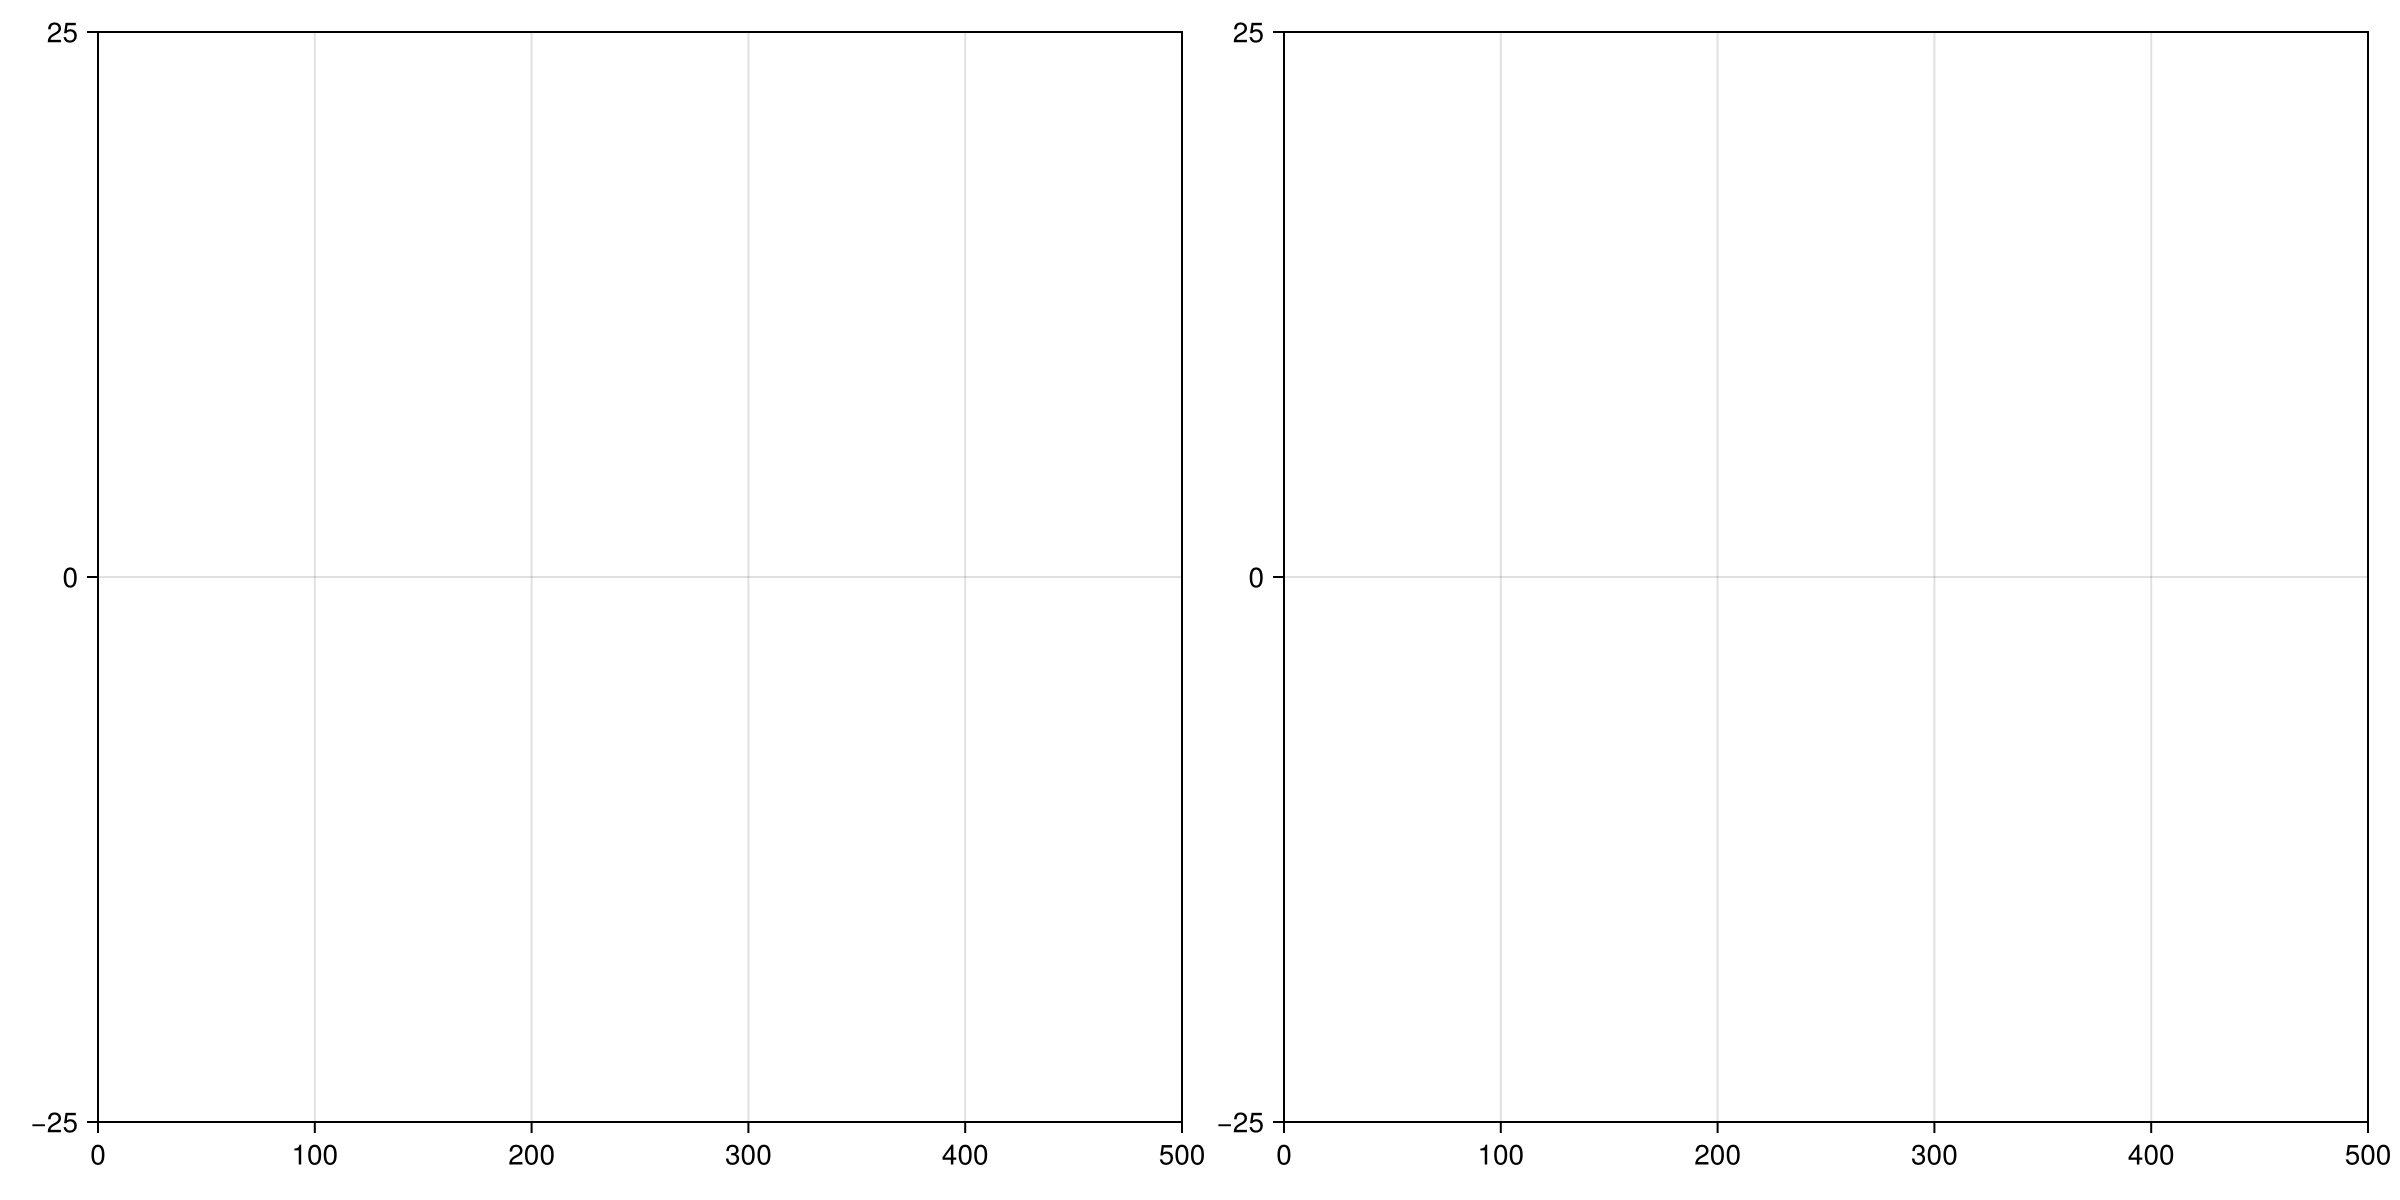

In [32]:
ON_preds_freerun = create_pred_for_params_free_run(4; k = 100)
vanilla_preds_freerun = create_pred_for_params_free_run(1; k = 400)

compare_preds(ON_preds_freerun, vanilla_preds_freerun, 0, 500, calculate_error=false)

## Multi step predictions

In [20]:
function multi_step_pred(initial_value, sub_part_symbols_test, state, R, ESN_params)
    pred, state = initial_value, state
    preds = [pred]
    
    for symbol in sub_part_symbols_test
        one_pred, one_state = one_step_pred(pred, ESN_params, R, S = state, partition_symbols=symbol)
        pred = one_pred[1]
        state = one_state[1,:]
        push!(preds, pred)
    end
    
    return(preds, state)
end

function create_pred_for_params_multi_step(m, chunk_length; k = 100, d = k*0.05, ρ = 1.1, α = 1.0, η = 1/maximum(lo_train), β = 0.001, w = 1, τ = 1)
    window_size = (m-1)*τ
    
    part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
    trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
    num_partitions = length(unique_partitions_train)
    trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

    ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, part_connection=0.1, ON_part_adjacency=trans_adjacency_map)

    R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train)

    part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
    
    preds = []
    current_state = train_states[end,:]
    current_true_value = lo_train[end]
    i = 1
    while i+chunk_length-1 < length(part_symbols_test)
        new_preds, _ = multi_step_pred(current_true_value, part_symbols_test[i:i+chunk_length-2], current_state, R, ESN_params)
        preds = vcat(preds, new_preds)

        states = run_ESN(lo_test[i:i+chunk_length-1], ESN_params; S = current_state, partition_symbols=part_symbols_test[i:i+chunk_length-1])
        current_state = states[1,:]
        
        current_true_value = lo_test[i+chunk_length-1]
        
        i = i + chunk_length
    end
    
    return(preds[2:end])
end

create_pred_for_params_multi_step (generic function with 1 method)

In [22]:
# ESN_params.V_rec

In [23]:
# mask_V_in_for_partition([1,1,1,1,1,1,1,1,1], 2, 3, 3)

In [24]:
# function test_mask_func(V_in, partition, k, num_partitions)
#     masked_V_in = zeros(k*num_partitions, num_partitions)
    
#     for part_i in 1:num_partitions
#         masked_V_in[(part_i-1)*k+1:part_i*k, part_i] .= 1
#     end
    
#     masked_V_in = masked_V_in*one_hot_encode(partition, num_partitions).*V_in
    
#     return(masked_V_in)
# end

# stts[50,:]
# # test_mask(stts[50,:], 1, )

In [25]:
ON_preds_multistep = create_pred_for_params_multi_step(3, 2; k = 400)
vanilla_preds_multistep = create_pred_for_params_multi_step(1, 2; k = 1200);

Ordinal network reservoir prediction RMSE: 1.6426654609401354
Vanilla prediction RMSE: 0.9291371833606827
Ordinal network reservoir prediction turning partition RMSE: 4.68094319371205
Vanilla prediction turning partition RMSE: 3.112945394665287


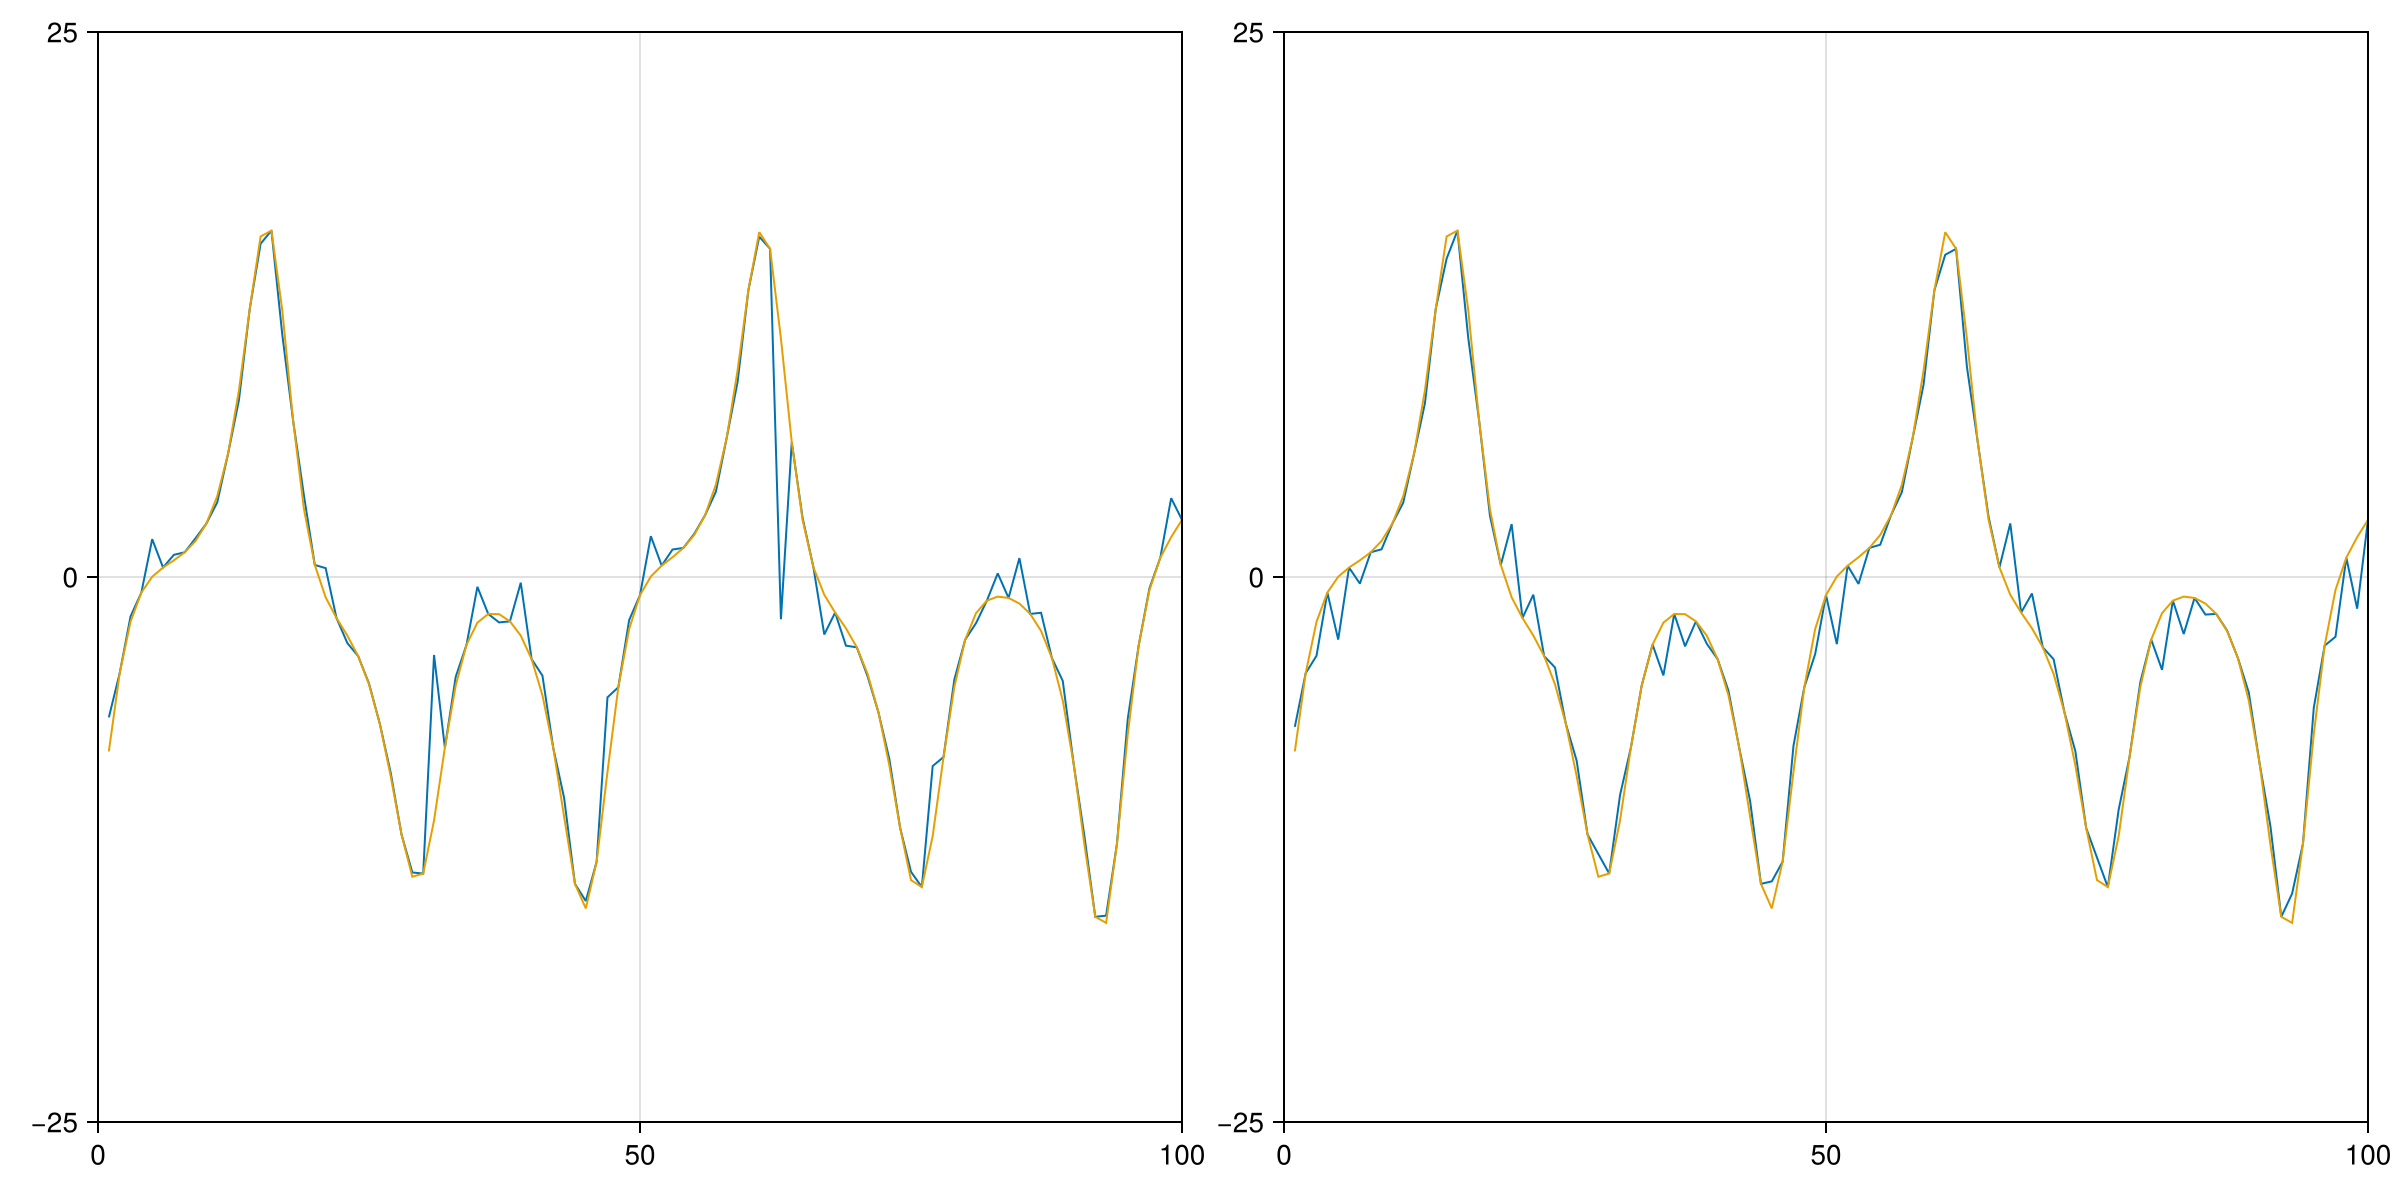

In [26]:
compare_preds(ON_preds_multistep, vanilla_preds_multistep, 0, 100, ignore_first=20, offset=0)

In [27]:
ON_preds_multistep = create_pred_for_params_multi_step(3, 3; k = 400)
vanilla_preds_multistep = create_pred_for_params_multi_step(1, 3; k = 1200);

Ordinal network reservoir prediction RMSE: 6.937057480243788
Vanilla prediction RMSE: 5.710465702125283
Ordinal network reservoir prediction turning partition RMSE: 14.776209501804008
Vanilla prediction turning partition RMSE: 5.754687399326348


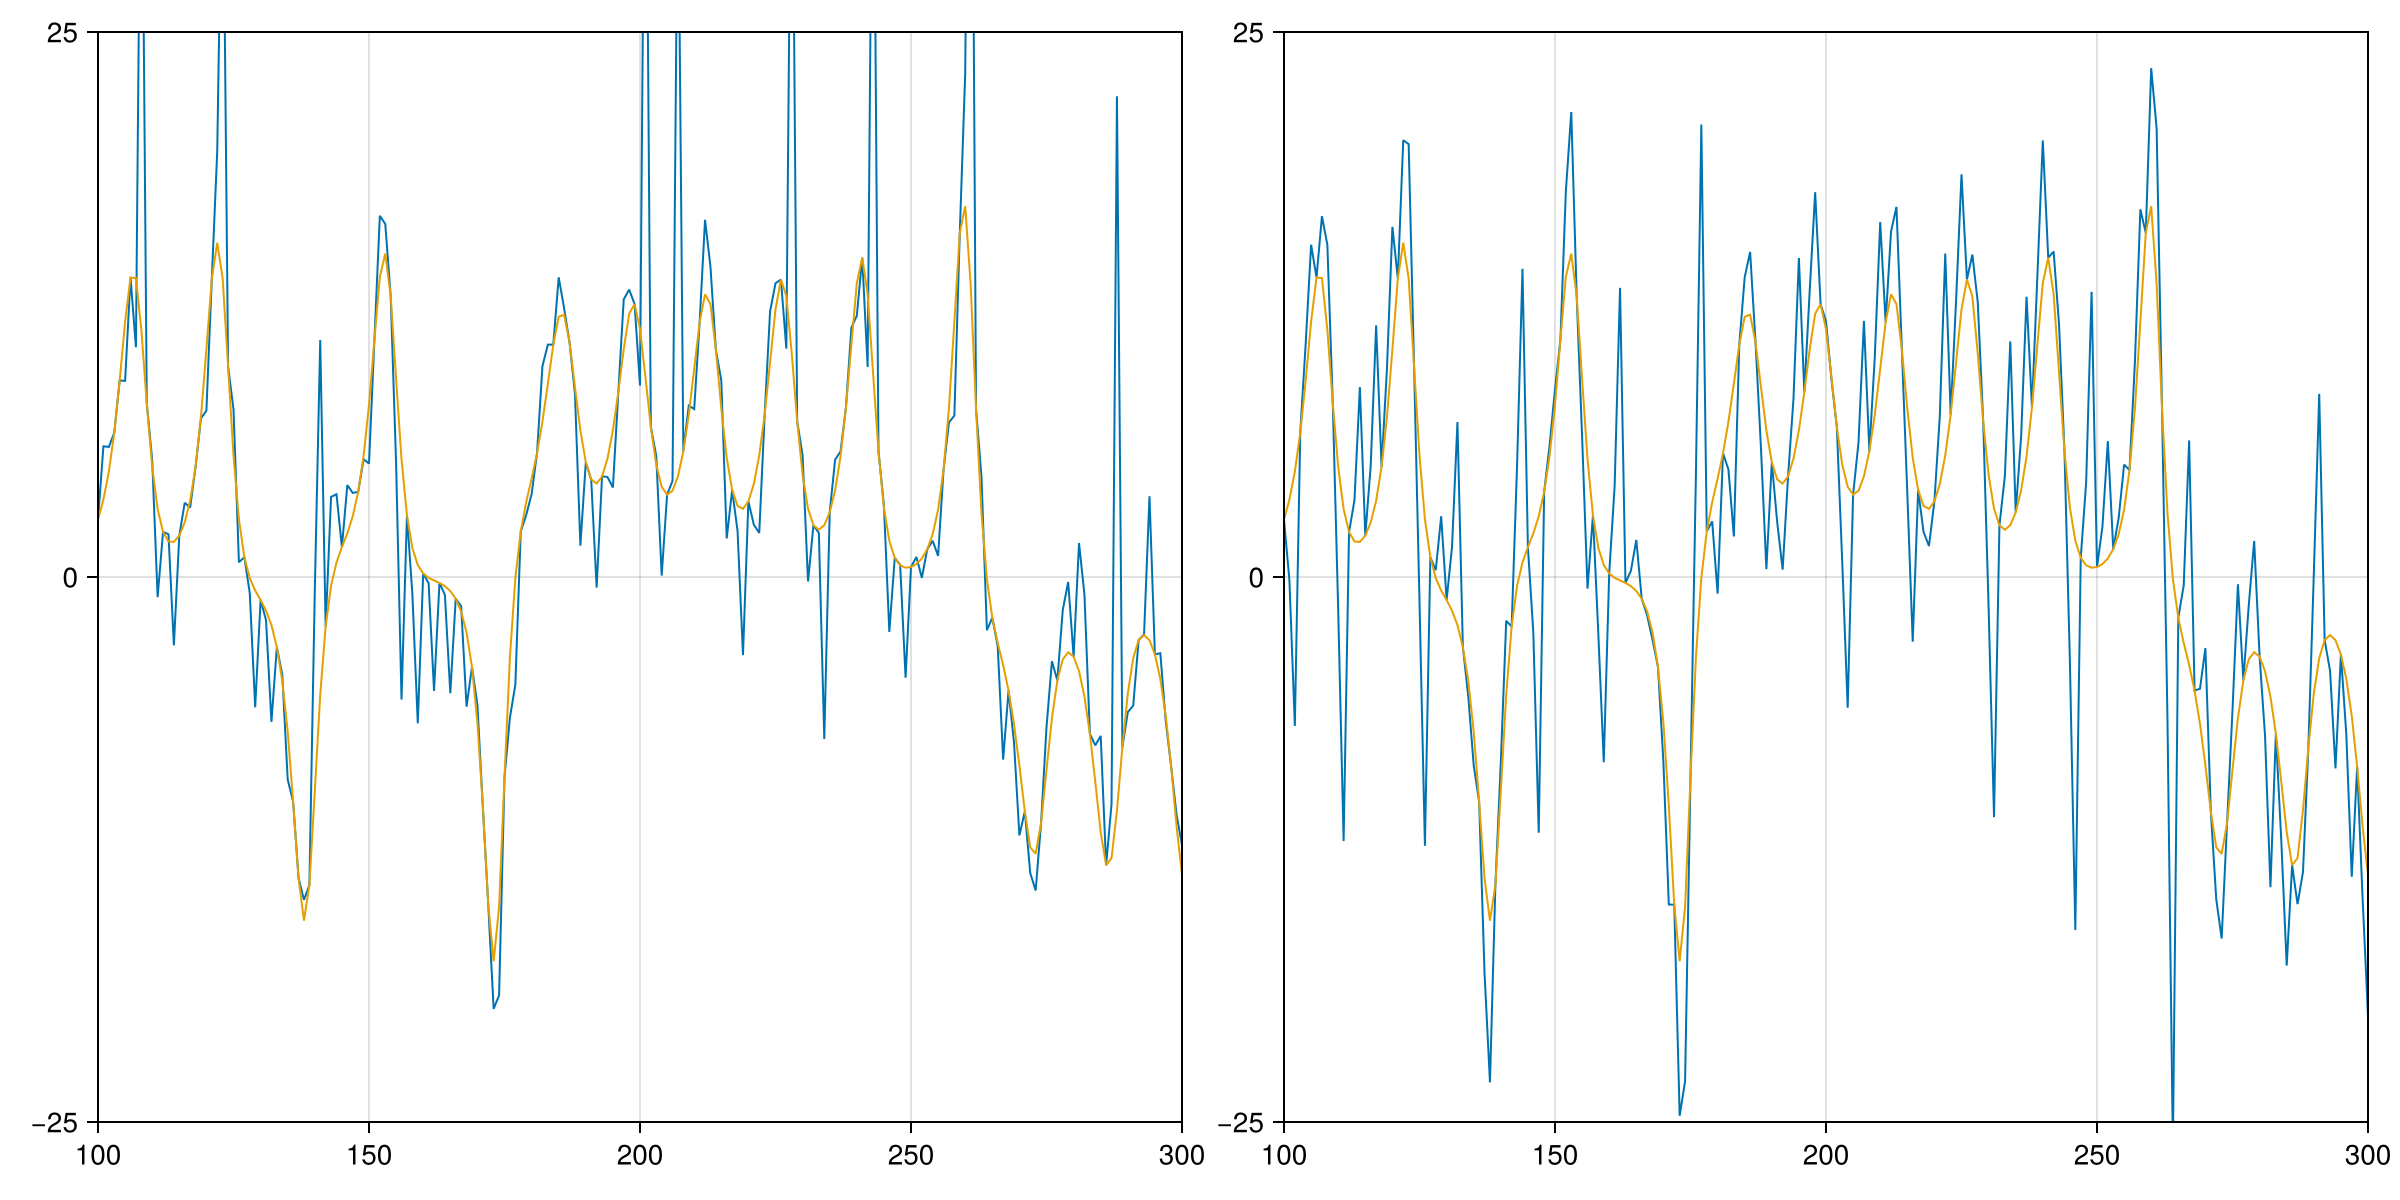

In [28]:
compare_preds(ON_preds_multistep, vanilla_preds_multistep, 100, 300, ignore_first=20, offset=0)

In [29]:
ON_preds_multistep = create_pred_for_params_multi_step(3, 4; k = 400)
vanilla_preds_multistep = create_pred_for_params_multi_step(1, 4; k = 1200);

Ordinal network reservoir prediction RMSE: 21.526147063268912
Vanilla prediction RMSE: 14.484932783313983
Ordinal network reservoir prediction turning partition RMSE: 46.70053178689948
Vanilla prediction turning partition RMSE: 10.712847101815347


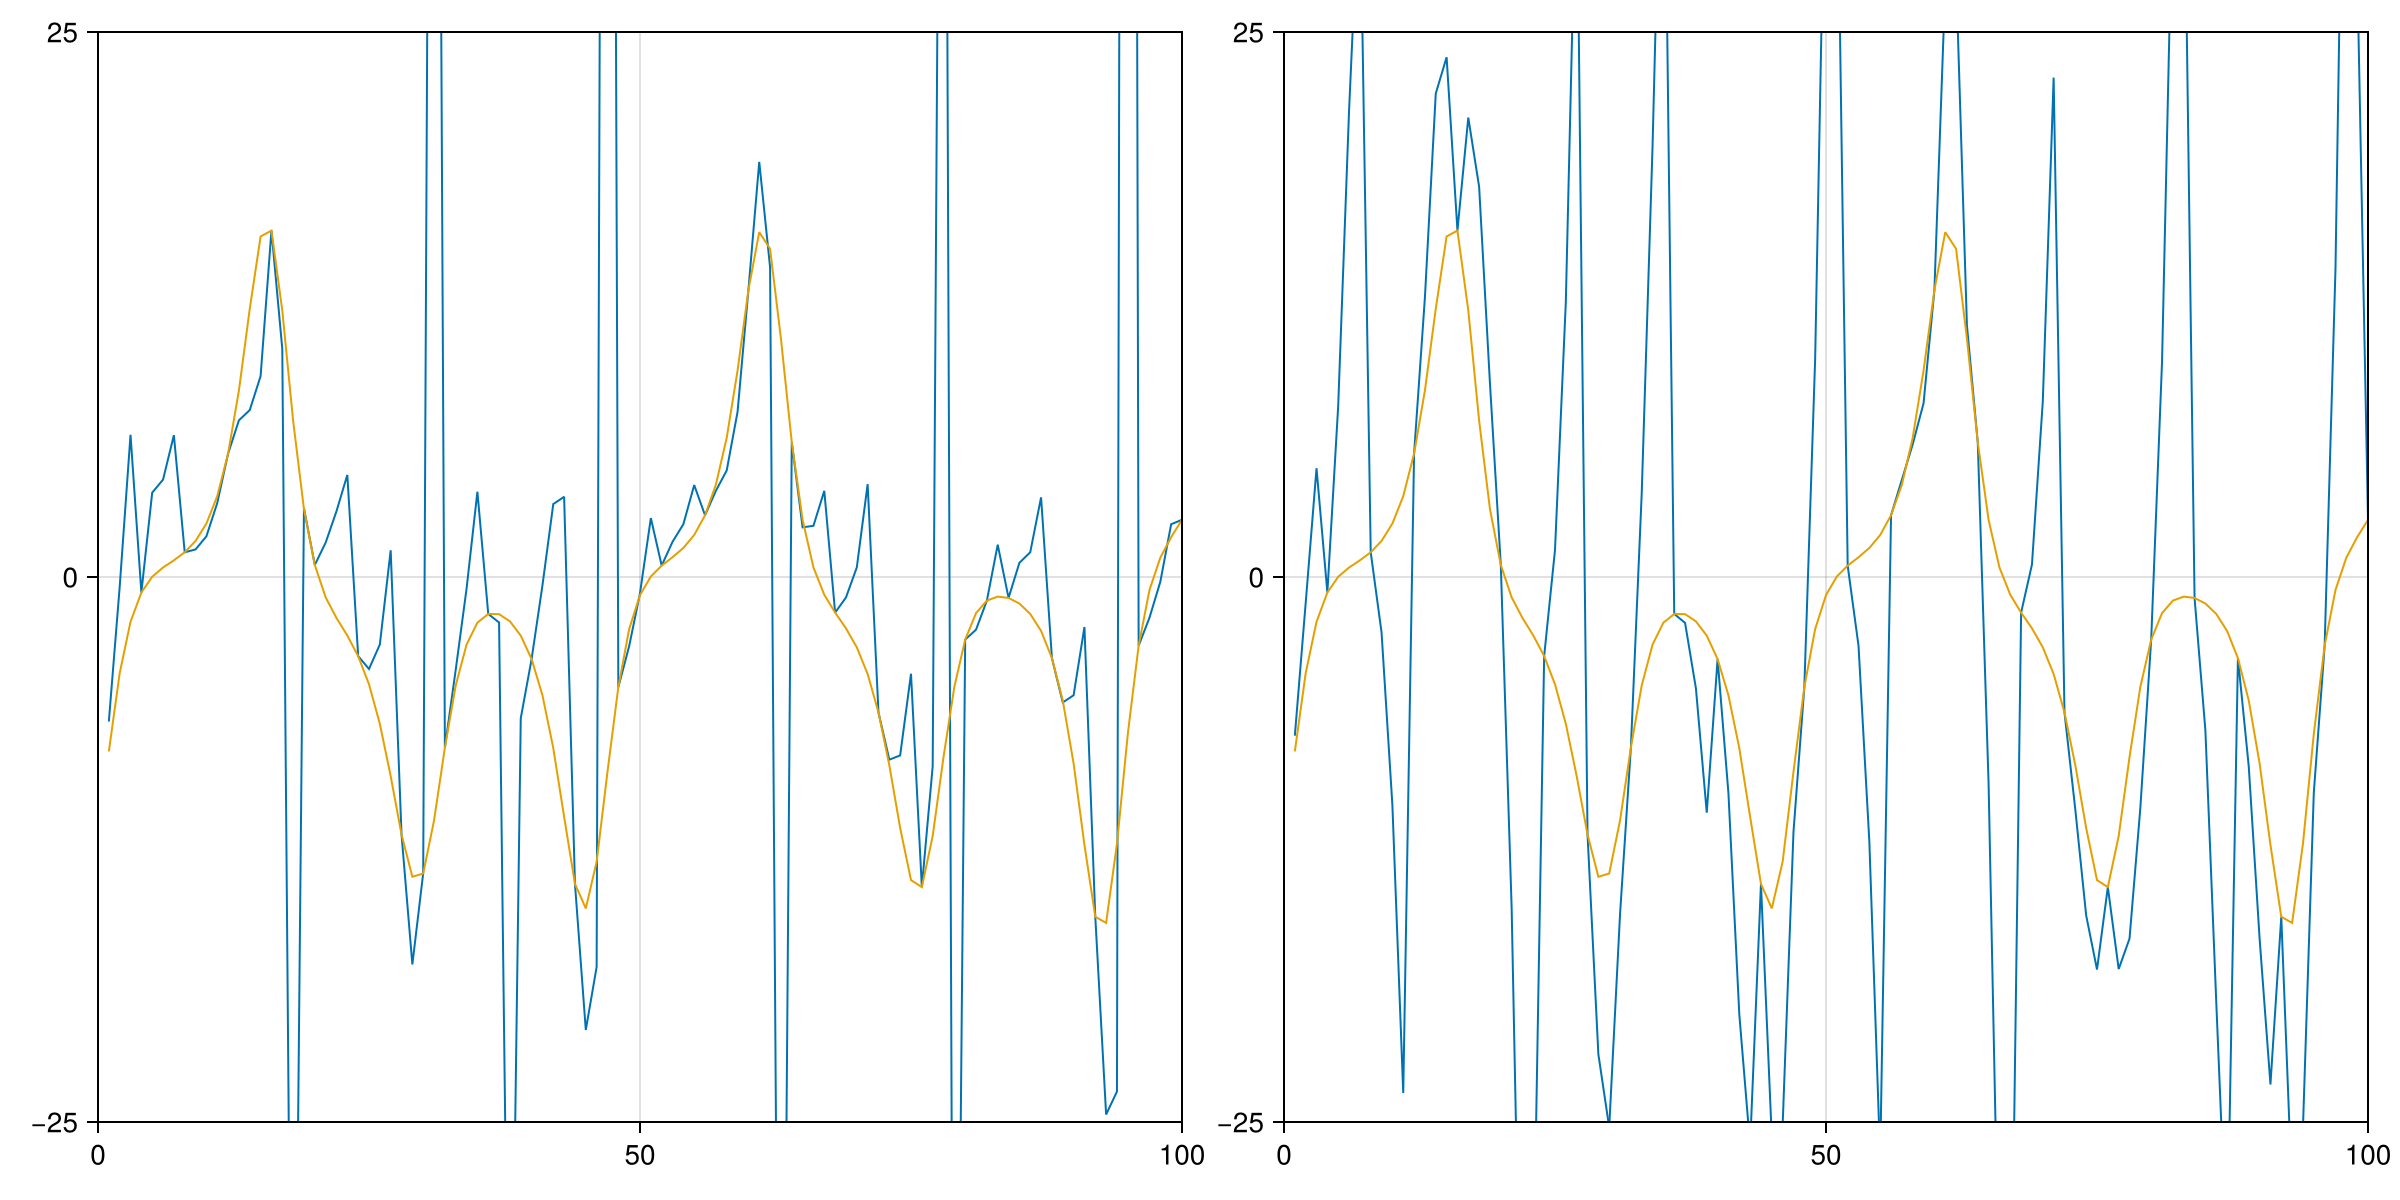

In [30]:
# compare_preds(ON_preds_multistep, vanilla_preds_multistep, 100, 300, ignore_first=20, offset=0)
compare_preds(ON_preds_multistep, vanilla_preds_multistep, 0, 100, ignore_first=20, offset=0)